# Check whether a SMIRNOFF-format force field is able to parametrize a dataset of interest

This notebook runs a quick initial analysis of whether a molecule set can be simulated by a given SMIRNOFF-format force field. While some attempt has been made to improve the speed of this code, it is not particuarly high-performance in its current state, and may crash the notebook you try to analyze more than 10,000 molecules. 

First, we define global variables, and create a helper function to check for parameterization failures. 

_It is not important to understand or modify the following two notebook cells._

In [1]:
import os
import time
from copy import deepcopy

import numpy as np
from IPython.display import display
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole

try:
    from openmm import unit
except ImportError:
    from simtk import unit

from openff.toolkit.topology import Molecule, Topology
from openff.toolkit.typing.engines.smirnoff import (
    AngleHandler,
    BondHandler,
    ForceField,
    ImproperTorsionHandler,
    ProperTorsionHandler,
    UnassignedValenceParameterException,

    vdWHandler,
)

# Define "super generics", which are parameters that will match
# each instance of a valence type. By adding these to a ForceField
# object, we ensure that a given ParameterHandler will not encounter
# a parameterization failure
super_generics = {
    "Bonds": BondHandler.BondType(
        smirks="[*:1]~[*:2]",
        k=0 * unit.kilocalorie / unit.mole / unit.angstrom ** 2,
        length=0 * unit.angstrom,
    ),
    "Angles": AngleHandler.AngleType(
        smirks="[*:1]~[*:2]~[*:3]",
        angle=0 * unit.degree,
        k=0 * unit.kilocalorie / unit.mole / unit.degree ** 2,
    ),
    "ProperTorsions": ProperTorsionHandler.ProperTorsionType(
        smirks="[*:1]~[*:2]~[*:3]~[*:4]",
        phase1=0 * unit.degree,
        periodicity1=0,
        k1=0 * unit.kilocalorie / unit.mole,
        idivf1=1,
    ),
    "ImproperTorsions": ImproperTorsionHandler.ImproperTorsionType(
        smirks="[*:1]~[*:2](~[*:3])~[*:4]",
        phase1=0 * unit.degree,
        periodicity1=0,
        k1=0 * unit.kilocalorie / unit.mole,
        idivf1=1,
    ),
    "vdW": vdWHandler.vdWType(
        smirks="[*:1]",
        rmin_half=0 * unit.angstrom,
        epsilon=0 * unit.kilocalorie / unit.mole,
    ),
}

In [2]:
def report_missing_parameters(molecule, forcefield):
    """
    Analyze a molecule using a provided ForceField, generating a report of any
    chemical groups in the molecule that are lacking parameters.

    Parameters
    ----------
    molecule : an openforcefield.topology.FrozenMolecule
        The molecule to analyze
    forcefield : an openforcefield.typing.engine.smirnoff.ForceField
        The ForceField object to use

    Returns
    -------
    missing_parameters : dict[tagname: list[dict[tagged_smiles:string, image:PIL.Image, atom indices:list[int]]]]
        A hierarchical dictionary, with first level keys indicating ForceField tag
        names (eg. "Bonds"), and first-level values which are lists of dictionaries.
        Each dictionary in this list reflects one missing parameter, and contains the
        following key:value pairs :
        * "image": PIL.Image
            * shows a 2D drawing, highlighting the feature that could not be parametrized
        * "tagged_smiles": string
            * SMILES of the whole molecule, tagging the atom indices which could not be
              parametrized
        * "atom_indices": tuple(int)
            * The indices of atoms which could not be parametrized

    """

    highlight_color = (0.75, 0.75, 0.75)

    # Make deepcopies of both inputs, since we may modify them in this function
    forcefield = deepcopy(forcefield)
    molecule = deepcopy(molecule)

    # Set partial charges to placeholder values so that we can skip AM1-BCC
    # during parameterization
    molecule.partial_charges = (
        np.zeros(molecule.n_atoms) + 0.1
    ) * unit.elementary_charge

    # Prepare dictionary to catch parameterization failure info
    success = False
    missing_params = {}

    while not success:
        # Try to parameterize the system, catching the exception if there is one.
        try:
            forcefield.create_openmm_system(
                molecule.to_topology(),
                charge_from_molecules=[molecule],
                allow_nonintegral_charges=True,
            )
            success = True
        except UnassignedValenceParameterException as e:
            success = False

            # Ensure that there is a list initialized for missing parameters
            # under this tagname
            handler_tagname = e.handler_class._TAGNAME
            if handler_tagname not in missing_params:
                missing_params[handler_tagname] = []

            # Create a shortcut to the topology atom tuples attached to
            # the parametrization error
            top_atom_tuples = e.unassigned_topology_atom_tuples

            # Make a summary of the missing parameters from this attempt and add it to
            # the missing_params dict
            rdmol = molecule.to_rdkit()
            for top_atom_tuple in top_atom_tuples:
                orig_atom_indices = [i.topology_atom_index for i in top_atom_tuple]
                # Make a copy of the input RDMol so that we don't modify the original
                this_rdmol = deepcopy(rdmol)

                # Attach tags to relevant atoms so that a tagged SMILES can be written
                orig_rdatoms = []
                for tag_idx, atom_idx in enumerate(orig_atom_indices):
                    rdatom = this_rdmol.GetAtomWithIdx(atom_idx)
                    rdatom.SetAtomMapNum(tag_idx + 1)
                    orig_rdatoms.append(rdatom)

                tagged_smiles = Chem.MolToSmiles(this_rdmol)

                # Make tagged hydrogens into deuteriums so that RemoveHs doesn't get rid of them
                for rdatom in orig_rdatoms:
                    if rdatom.GetAtomicNum() == 1:
                        rdatom.SetIsotope(2)

                # Remove hydrogens, since they clutter up the 2D drawing
                # (tagged Hs are not removed, since they were converted to deuterium)
                h_less_rdmol = Chem.RemoveHs(this_rdmol)

                # Generate 2D coords, since drawing from 3D can look really weird
                Draw.rdDepictor.Compute2DCoords(h_less_rdmol)

                # Search over the molecule to find the indices of the tagged atoms
                # after hydrogen removal
                h_less_atom_indices = [None for i in orig_atom_indices]
                for rdatom in h_less_rdmol.GetAtoms():
                    # Convert deuteriums back into hydrogens
                    if rdatom.GetAtomicNum() == 1:
                        rdatom.SetIsotope(1)

                    atom_map_num = rdatom.GetAtomMapNum()
                    if atom_map_num == 0:
                        continue
                    h_less_atom_indices[atom_map_num - 1] = rdatom.GetIdx()

                # Once the new atom indices are found, use them to find the H-less
                # bond indices
                h_less_rdbonds = []
                for i in range(len(h_less_atom_indices) - 1):
                    rdbond = h_less_rdmol.GetBondBetweenAtoms(
                        h_less_atom_indices[i],
                        h_less_atom_indices[i + 1],
                    )
                    h_less_rdbonds.append(rdbond)
                h_less_bond_indices = [bd.GetIdx() for bd in h_less_rdbonds]

                # Create a 2D drawing of the molecule, highlighting the
                # parameterization failure
                highlight_atom_colors = {
                    idx: highlight_color for idx in h_less_atom_indices
                }
                highlight_bond_colors = {
                    idx: highlight_color for idx in h_less_bond_indices
                }
                image = Draw.MolsToGridImage(
                    [h_less_rdmol],
                    highlightAtomLists=[h_less_atom_indices],
                    highlightBondLists=[h_less_bond_indices],
                    molsPerRow=1,
                    highlightAtomColors=[highlight_atom_colors],
                    highlightBondColors=[highlight_bond_colors],
                    subImgSize=(600, 600),
                    returnPNG=False,
                )

                # Structure and append the relevant info to the missing_params dictionary
                param_description = {
                    "atom_indices": orig_atom_indices,
                    "image": image,
                    "tagged_smiles": tagged_smiles,
                }
                missing_params[handler_tagname].append(param_description)

            # Add a "super generic" parameter to the top of this handler's ParameterList,
            # which will make it always find parameters for each term. This will prevent the same
            # parameterization exception from being raised in the next attempt.
            param_list = forcefield.get_parameter_handler(handler_tagname).parameters
            param_list.insert(0, super_generics[handler_tagname])

    return missing_params

# Loading the molecule dataset

There are several ways to load molecules into the Open Force Field Toolkit. Below, we show how to load molecule databases from `.smi`, `.sdf`, and  `.mol2` format files. It's important that these databases contain a _complete_ representation of each molecule, including formal charge, stereochemistry, and protonation state.

_Note that loading `.mol2` files is currently only supported using the OpenEye Toolkit._

### Option 1: Load a SMILES dataset

In [3]:
molecules = Molecule.from_file("example_molecules.smi", allow_undefined_stereo=True)

# We also provide a SMILES dataset of ~1000 problematic molecules
# molecules =  Molecule.from_file('problem_smiles.smi', allow_undefined_stereo=True)

print(f"Loaded {len(molecules)} molecules")

Loaded 4 molecules


### Option 2: Load a SDF dataset 

In [ ]:
molecules = Molecule.from_file("example_molecules.sdf", allow_undefined_stereo=True)
print(f"Loaded {len(molecules)} molecules")

### Option 3: Load a mol2 dataset 
**This option requires the OpenEye Toolkit!**

In [ ]:
try:
    molecules = Molecule.from_file(
        "example_molecules.mol2",
        allow_undefined_stereo=True,
    )
    print(f"Loaded {len(molecules)} molecules")
except NotImplementedError as e:
    print(e)
    print("Loading mol2 files requires the OpenEye Toolkits")

## Analyze all molecules in the data set

### Option 1: Live visualization (single thread: ~1 second per molecule)

Here, we run the above-defined function on all molecules in the dataset. The parameterization failures will be shown in the notebook as the data set is processed. 

_Note: If the dataset is large this will take a very long time, and displaying all parameterization failures may run into memory/output limits in the notebook. If you're analyzing more than ~1,000 molecules, use `Option 2` below._





Processing "molecule_1" with smiles [H][c]1[c]([H])[c]([H])[c]([H])[c]([H])[c]1[H]
Molecule analysis took 0.20192813873291016 seconds




Processing "molecule_2" with smiles [H][c]1[c]([Cl])[c]([H])[c]([C](=[O])[N]=[P]([N]([C]([H])([H])[H])[C]([H])([H])[H])([N]([C]([H])([H])[H])[C]([H])([H])[H])[C]([Hg][C]([H])([H])[H])([C]([H])([H])[H])[C]([H])([H])[H])[c]([H])[c]1[Cl]
Molecule analysis took 1.5397446155548096 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ProperTorsions
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
[H]c1c(Cl)c([H])c(C(=O)N=P(N(C([H])([H])[H])C([H])([H])[H])(N(C([H])([H])[H])C([H])([H])[H])[C:1](C([H])([H])[H])(C([H])([H])[H])[Hg:2][C:3]([H])([H])[H:4])c([H])c1Cl


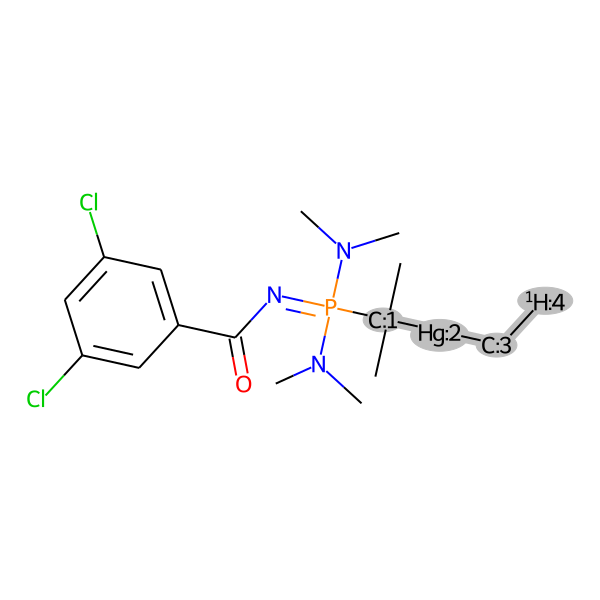

[H]c1c(Cl)c([H])c(C(=O)N=P(N(C([H])([H])[H])C([H])([H])[H])(N(C([H])([H])[H])C([H])([H])[H])[C:3](C([H])([H])[H])([Hg:2][C:1]([H])([H])[H])[C:4]([H])([H])[H])c([H])c1Cl


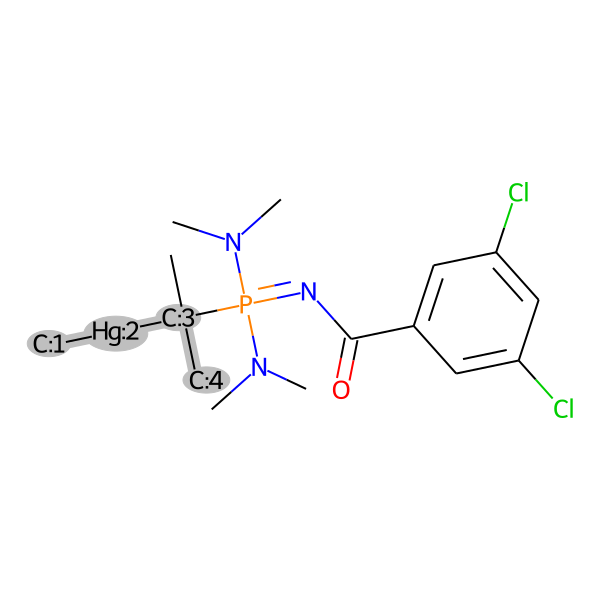

[H]c1c(Cl)c([H])c(C(=O)N=[P:4](N(C([H])([H])[H])C([H])([H])[H])(N(C([H])([H])[H])C([H])([H])[H])[C:3](C([H])([H])[H])(C([H])([H])[H])[Hg:2][C:1]([H])([H])[H])c([H])c1Cl


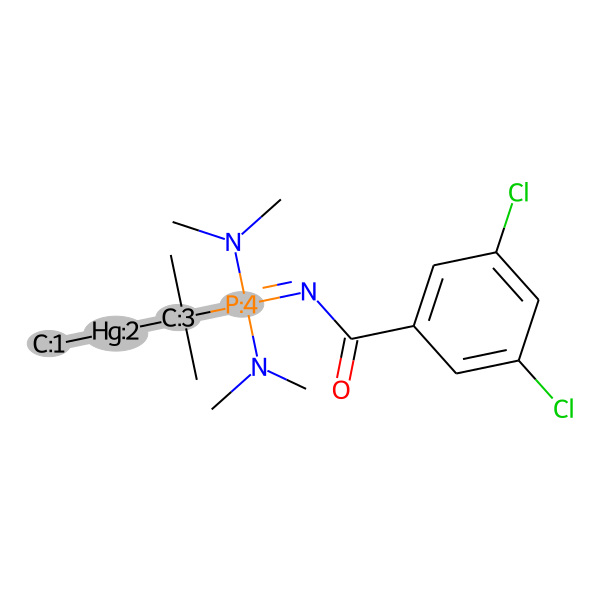

[H]c1c(Cl)c([H])c(C(=O)N=P(N(C([H])([H])[H])C([H])([H])[H])(N(C([H])([H])[H])C([H])([H])[H])[C:1](C([H])([H])[H])(C([H])([H])[H])[Hg:2][C:3]([H])([H])[H:4])c([H])c1Cl


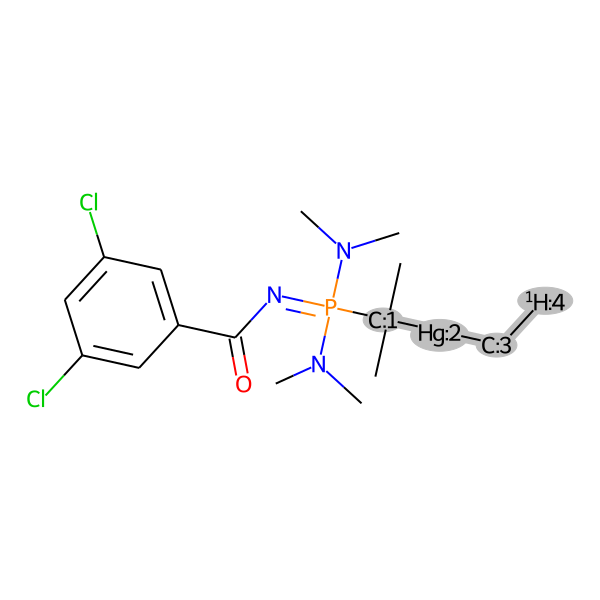

[H]c1c(Cl)c([H])c(C(=O)N=P(N(C([H])([H])[H])C([H])([H])[H])(N(C([H])([H])[H])C([H])([H])[H])[C:1](C([H])([H])[H])(C([H])([H])[H])[Hg:2][C:3]([H])([H])[H:4])c([H])c1Cl


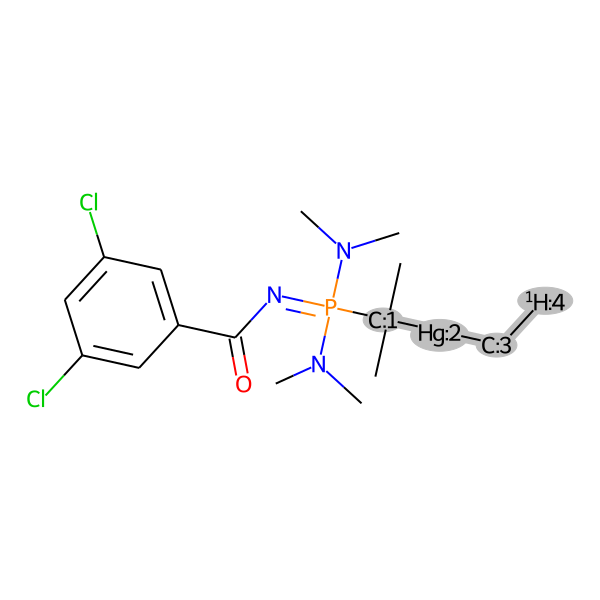

[H]c1c(Cl)c([H])c(C(=O)N=P(N(C([H])([H])[H])C([H])([H])[H])(N(C([H])([H])[H])C([H])([H])[H])[C:3](C([H])([H])[H])([Hg:2][C:1]([H])([H])[H])[C:4]([H])([H])[H])c([H])c1Cl


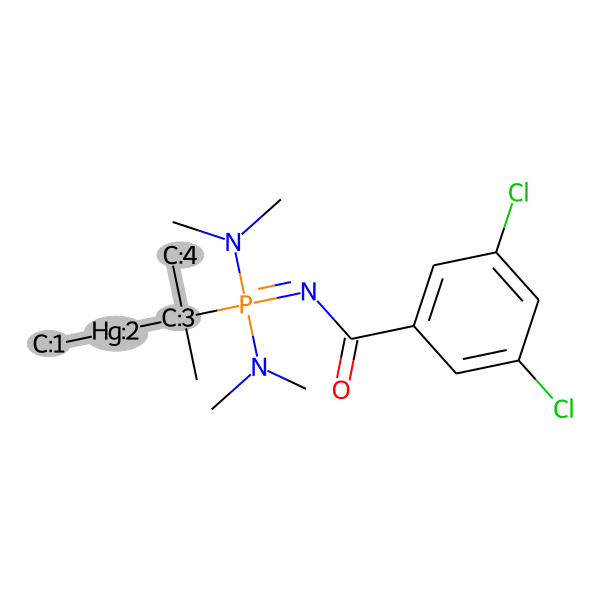

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
vdW
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
[H]c1c(Cl)c([H])c(C(=O)N=P(N(C([H])([H])[H])C([H])([H])[H])(N(C([H])([H])[H])C([H])([H])[H])C(C([H])([H])[H])(C([H])([H])[H])[Hg:1]C([H])([H])[H])c([H])c1Cl


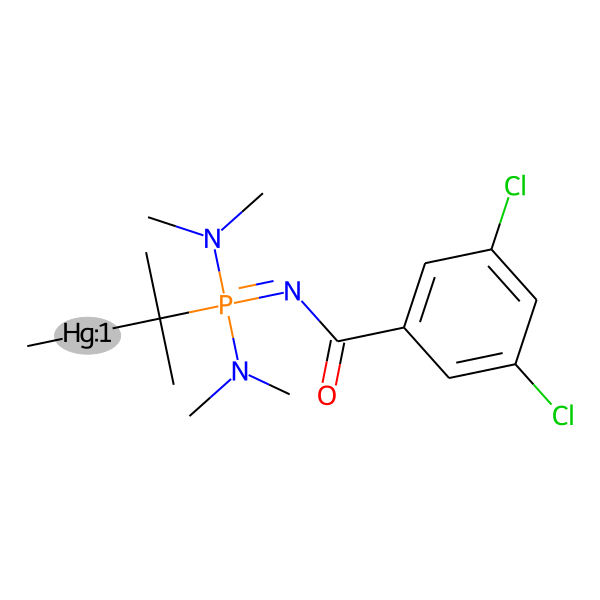

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Bonds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
[H]c1c(Cl)c([H])c(C(=O)N=P(N(C([H])([H])[H])C([H])([H])[H])(N(C([H])([H])[H])C([H])([H])[H])[C:2](C([H])([H])[H])(C([H])([H])[H])[Hg:1]C([H])([H])[H])c([H])c1Cl


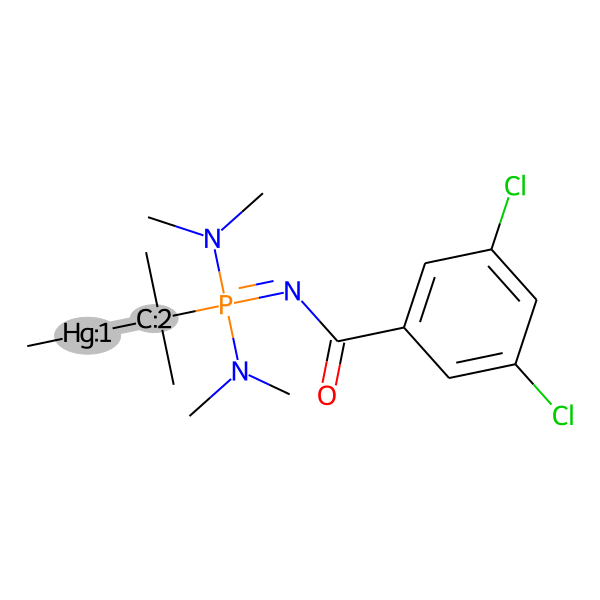

[H]c1c(Cl)c([H])c(C(=O)N=P(N(C([H])([H])[H])C([H])([H])[H])(N(C([H])([H])[H])C([H])([H])[H])C(C([H])([H])[H])(C([H])([H])[H])[Hg:2][C:1]([H])([H])[H])c([H])c1Cl


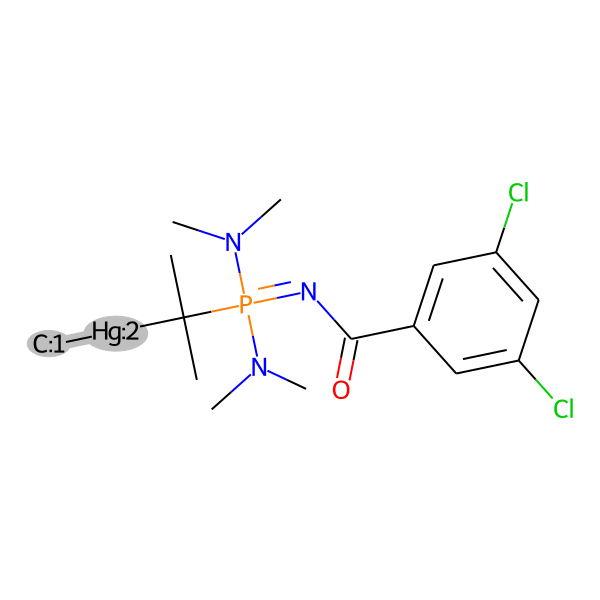

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Angles
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
[H]c1c(Cl)c([H])c(C(=O)N=P(N(C([H])([H])[H])C([H])([H])[H])(N(C([H])([H])[H])C([H])([H])[H])[C:3](C([H])([H])[H])(C([H])([H])[H])[Hg:2][C:1]([H])([H])[H])c([H])c1Cl


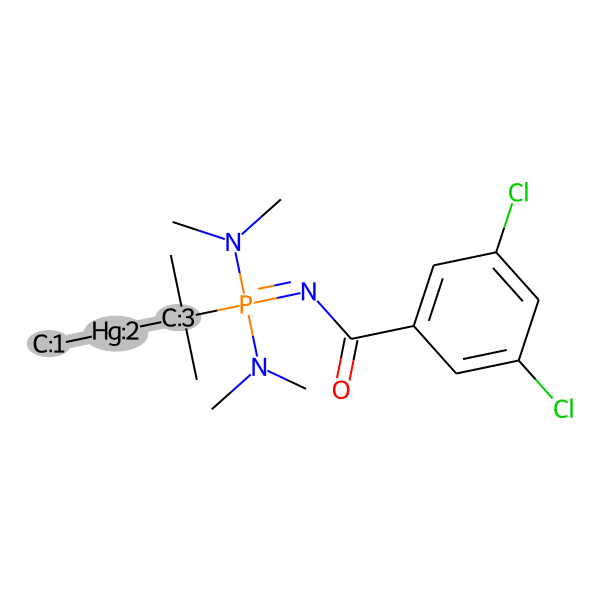





Processing "molecule_3" with smiles [H][c]1[c]([H])[c]([H])[c]([C]2=[c]3[n][c]([C]([H])([H])[H])[c]([H])[c]([C]([H])([H])[H])[n+]3=[C]([S][C]([H])([H])[H])[S]2)[c]([H])[c]1[H]
Molecule analysis took 0.5310275554656982 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ProperTorsions
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
[H]c1c([H])c([H])c(C2=[c:1]3nc(C([H])([H])[H])c([H])c(C([H])([H])[H])[n+:2]3=[C:3](SC([H])([H])[H])[S:4]2)c([H])c1[H]


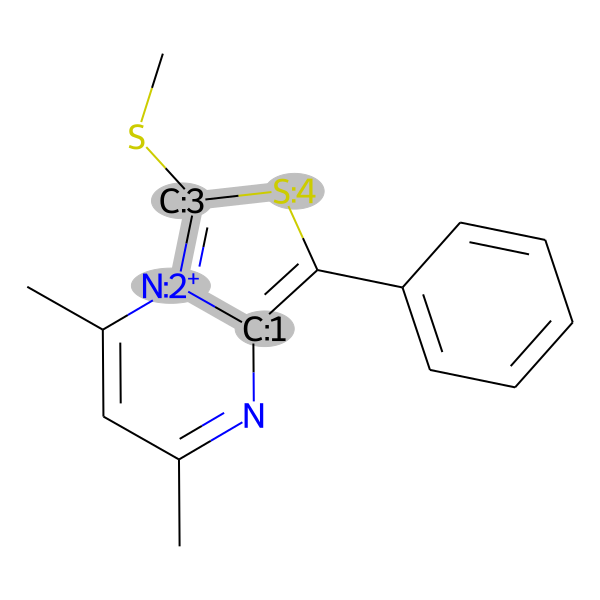

[H]c1c([H])c([H])c(C2=[c:1]3nc(C([H])([H])[H])c([H])c(C([H])([H])[H])[n+:2]3=[C:3]([S:4]C([H])([H])[H])S2)c([H])c1[H]


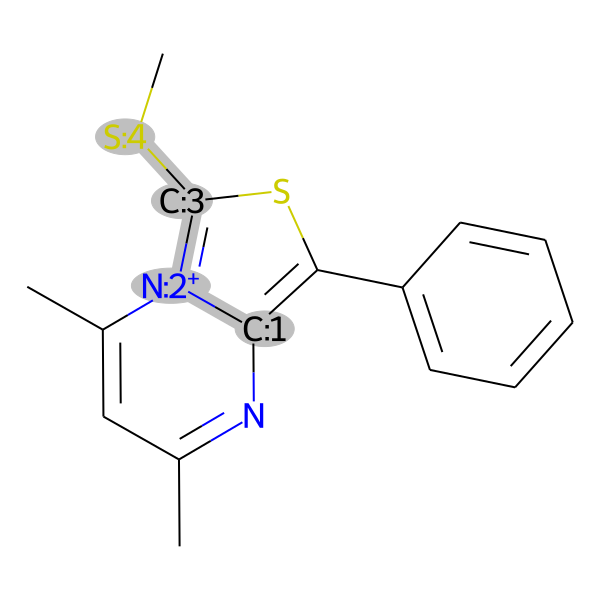

[H]c1c([H])c([H])c(C2=c3nc(C([H])([H])[H])c([H])[c:1](C([H])([H])[H])[n+:2]3=[C:3]([S:4]C([H])([H])[H])S2)c([H])c1[H]


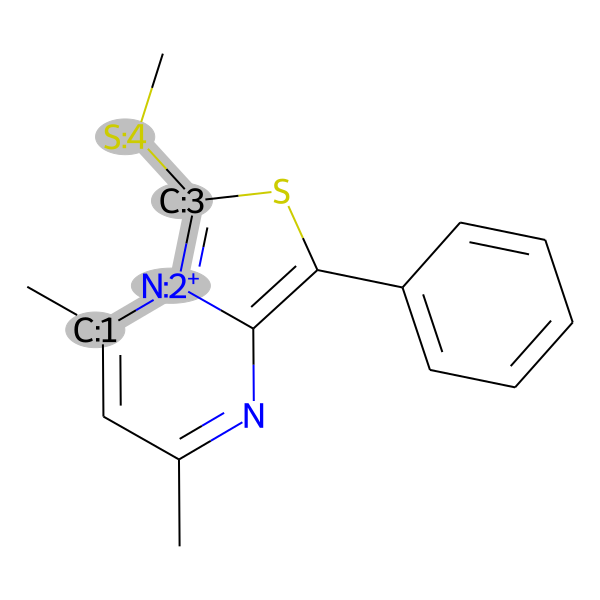

[H]c1c([H])c([H])c(C2=c3nc(C([H])([H])[H])c([H])[c:1](C([H])([H])[H])[n+:2]3=[C:3](SC([H])([H])[H])[S:4]2)c([H])c1[H]


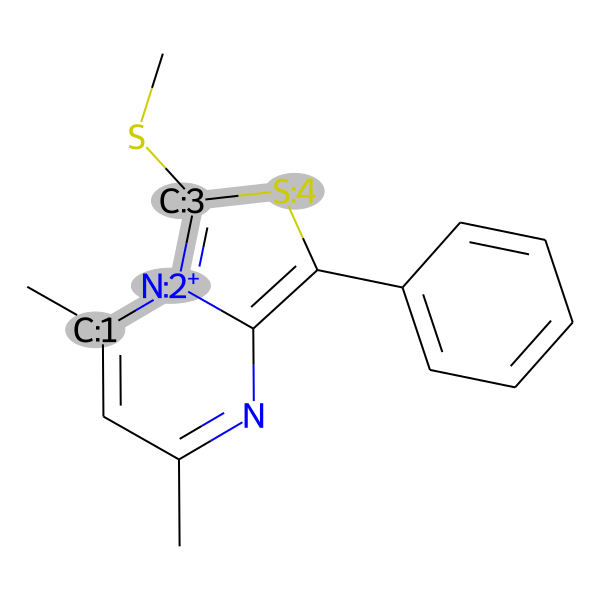





Processing "molecule_4" with smiles [H][C]([H])([O][P]1([O][C]([H])([H])[C]([H])([H])[C]([F])([F])[F])=[N][P]([O][C]([H])([H])[C]([H])([H])[C]([F])([F])[F])([O][C]([H])([H])[C]([H])([H])[C]([F])([F])[F])=[N][P]([O][C]([H])([H])[C]([H])([H])[C]([F])([F])[F])([O][C]([H])([H])[C]([H])([H])[C]([F])([F])[F])=[N]1)[C]([H])([H])[C]([F])([F])[F]
Molecule analysis took 0.8897061347961426 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ProperTorsions
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:1](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:2][P:3](OC([H])([H])C([H])([H])C(F)(F)F)([O:4]C([H])([H])C([H])([H])C(F)(F)F)=N1)C([H])([H])C(F)(F)F


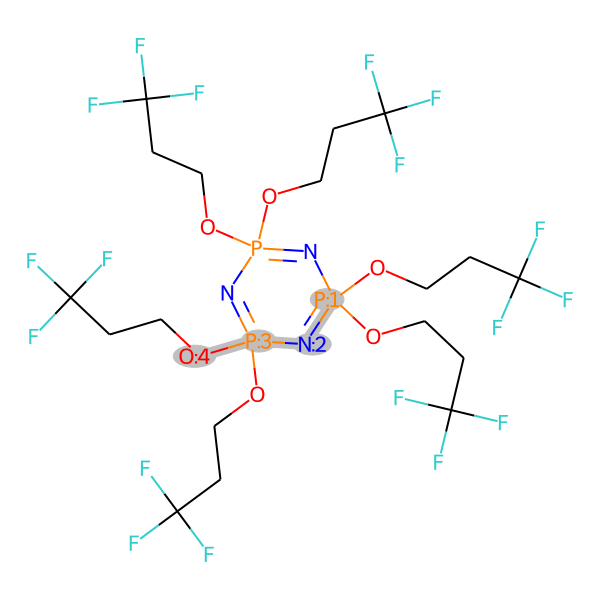

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:1](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:2][P:3](OC([H])([H])C([H])([H])C(F)(F)F)([O:4]C([H])([H])C([H])([H])C(F)(F)F)=N1)C([H])([H])C(F)(F)F


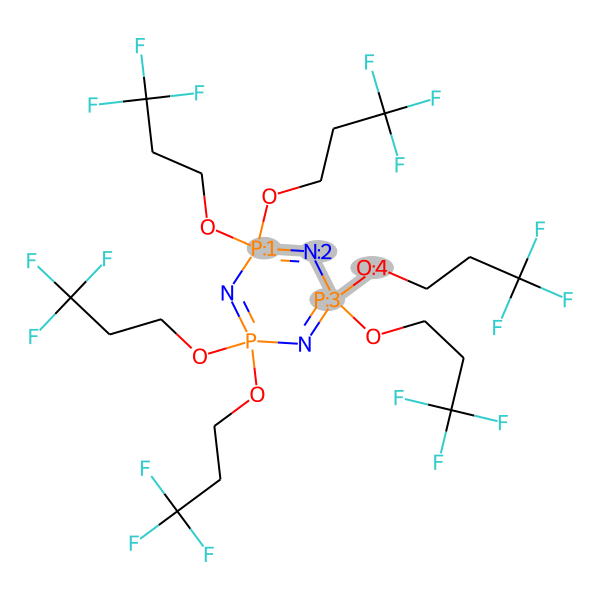

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:1](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:2][P:3](OC([H])([H])C([H])([H])C(F)(F)F)([O:4]C([H])([H])C([H])([H])C(F)(F)F)=N1)C([H])([H])C(F)(F)F


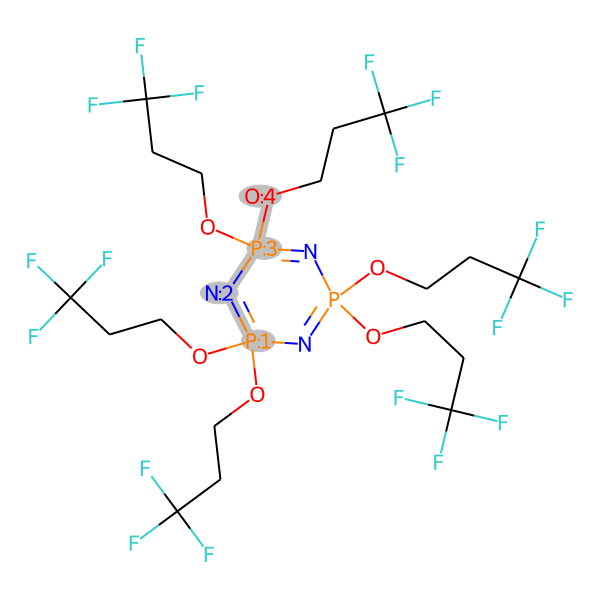

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:1](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:2][P:3](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:4]1)C([H])([H])C(F)(F)F


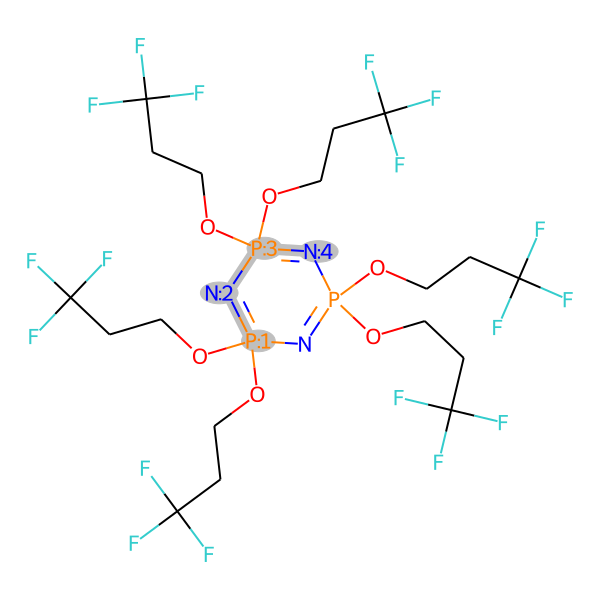

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:4](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:3][P:2](OC([H])([H])C([H])([H])C(F)(F)F)([O:1]C([H])([H])C([H])([H])C(F)(F)F)=N1)C([H])([H])C(F)(F)F


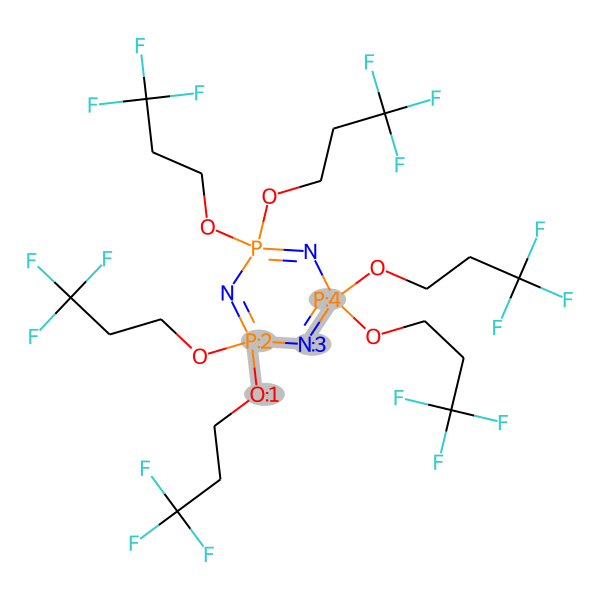

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:4](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:3][P:2](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:1]1)C([H])([H])C(F)(F)F


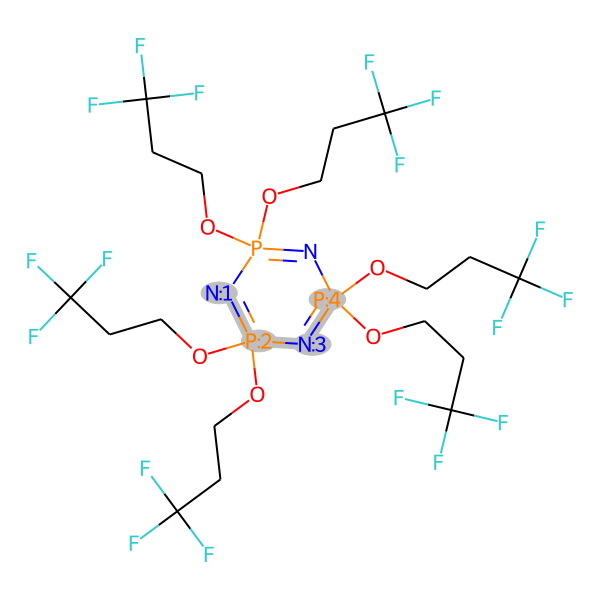

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:1](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:2][P:3](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:4]1)C([H])([H])C(F)(F)F


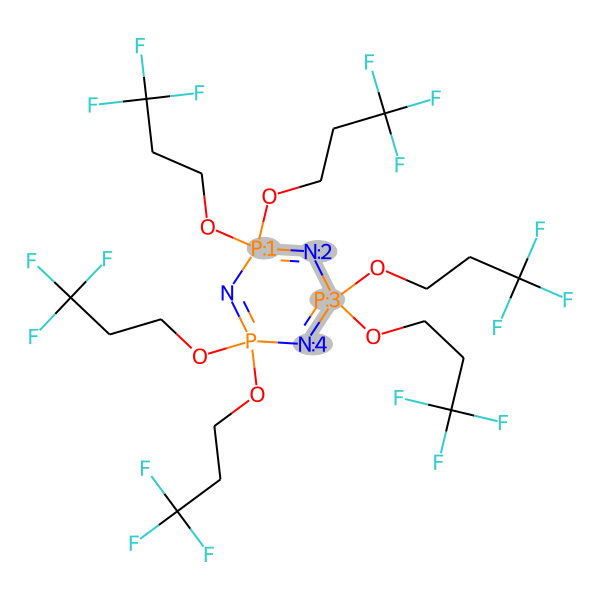

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:1](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:2][P:3](OC([H])([H])C([H])([H])C(F)(F)F)([O:4]C([H])([H])C([H])([H])C(F)(F)F)=N1)C([H])([H])C(F)(F)F


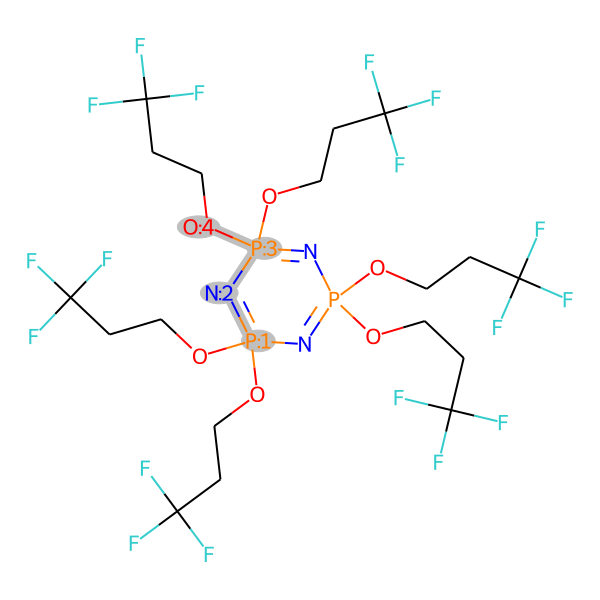

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:1](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:2][P:3](OC([H])([H])C([H])([H])C(F)(F)F)([O:4]C([H])([H])C([H])([H])C(F)(F)F)=N1)C([H])([H])C(F)(F)F


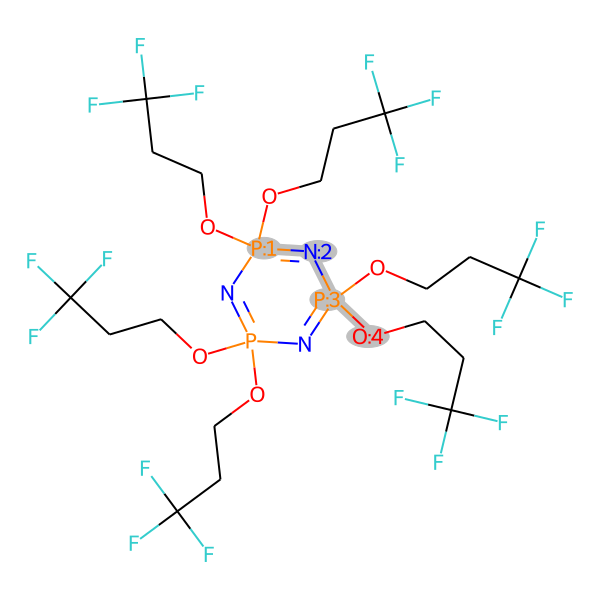

Processing 4 molecules took 3.6240975856781006 seconds


In [4]:
start_time = time.time()

forcefield = ForceField("openff-2.0.0.offxml")

results = {}

for mol_idx, molecule in enumerate(molecules):
    # Prepare a title for this molecule
    if molecule.name == "":
        mol_name = f"molecule_{mol_idx+1}"
    else:
        mol_name = molecule.name
    print("\n" * 3)
    print("=" * 60)
    print("=" * 60)
    print(f'Processing "{mol_name}" with smiles {molecule.to_smiles()}')
    print("=" * 60)
    print("=" * 60)

    # Analyze missing parameters
    time_i = time.time()
    missing_params = report_missing_parameters(molecule, forcefield)
    print(f"Molecule analysis took {time.time()-time_i} seconds")

    results[mol_name] = missing_params
    for tagname, missing_tag_params in missing_params.items():
        print("~" * 60)
        print(tagname)
        print("~" * 60)
        for missing_param in missing_tag_params:
            print(missing_param["tagged_smiles"])
            display(missing_param["image"])

print(f"Processing {len(molecules)} molecules took {time.time()-start_time} seconds")

### Option 2: No live visualization (multiple threads: ~(1/num_threads) seconds per molecule)

This method is faster than `Option 1`, but will not display unparameterizable chemistry in the notebook. 2D depictions and tagged SMILES of unparameterizable chemistry will be written to file in the final cell of the notebook. 

This will by default use 75% of the system's CPUs. If this is not desired, manually set `num_threads` below.

In [5]:
from multiprocessing import Pool, cpu_count, set_start_method

set_start_method("fork")

num_threads = max(1, int(cpu_count() * 0.75))


def check_molecule(inputs):
    mol_idx = inputs[0]
    molecule = inputs[1]
    forcefield = ForceField("openff-2.0.0.offxml")

    # Prepare a title for this molecule
    if molecule.name == "":
        mol_name = f"molecule_{mol_idx+1}"
    else:
        mol_name = molecule.name
    print("\n" * 3)
    print("=" * 60)
    print("=" * 60)
    print(f'Processing "{mol_name}" with smiles {molecule.to_smiles()}')
    print("=" * 60)
    print("=" * 60)
    # Analyze missing parameters
    time_i = time.time()
    missing_params = report_missing_parameters(molecule, forcefield)
    print(f"Molecule analysis took {time.time()-time_i} seconds")

    return (mol_name, missing_params)


start_time = time.time()
p = Pool(num_threads)
job_args = [(idx, molecule) for idx, molecule in enumerate(molecules)]
result_list = p.map(check_molecule, job_args)
results = dict(result_list)


print(f"Processing {len(molecules)} molecules took {time.time()-start_time} seconds")














============================================================Processing "molecule_1" with smiles [H][c]1[c]([H])[c]([H])[c]([H])[c]([H])[c]1[H]

Processing "molecule_2" with smiles [H][c]1[c]([Cl])[c]([H])[c]([C](=[O])[N]=[P]([N]([C]([H])([H])[H])[C]([H])([H])[H])([N]([C]([H])([H])[H])[C]([H])([H])[H])[C]([Hg][C]([H])([H])[H])([C]([H])([H])[H])[C]([H])([H])[H])[c]([H])[c]1[Cl]

============================================================Processing "molecule_4" with smiles [H][C]([H])([O][P]1([O][C]([H])([H])[C]([H])([H])[C]([F])([F])[F])=[N][P]([O][C]([H])([H])[C]([H])([H])[C]([F])([F])[F])([O][C]([H])([H])[C]([H])([H])[C]([F])([F])[F])=[N][P]([O][C]([H])([H])[C]([H])([H])[C]([F])([F])[F])([O][C]([H])([H])[C]([H])([H])[C]([F])([F])[F])=[N]1)[C]([H])([H])[C]([F])([F])[F]







Processing "molecule_3" with smiles [H][c]1[c]([H])[c]([H])[c]([C]2=[c]3[n][c]([C]([H])([H])[H])[c]([H])[c]([C]([H])([H])[H])[n+]3=[C]([S][C]([H])([H])[H])[S]2)[c]([H])[c]1[H]
Molecule analysis took 0

## Write a report of parameterization failures

Since the results from above are only held in memory during this Python session, it can be helpful to save this analysis to disk. 

The following code will write files containing a 2D image and a tagged SMILES for each unparameterizable motif found above. Results for each molecule are saved to different folders. If molecule names were not provided, these folders will be named `molecule_N/`, where N is the order in which the molecules were read. A single molecule may have multiple parameterization failures, and each one is written both as an image (eg. `molecule_2/Bonds_1-2.png`) and a tagged SMILES (eg. `molecule_2/Bonds_1-2.smi`).

_Note that this does not clear previous outputs, so it is possible that running this script on several datasets will overwrite or mix data with previous runs. Run `rm -r molecule_*` between runs to prevent potential issues._

When a molecule contains even one instance of unparameterizable chemistry, it can result in a large number of `ProperTorsions` failures being reported. To help reduce redundancy in these cases, the code below groups `ProperTorsions` output such that the atom indices defining the central bond are written first in the file name, followed by the atom indices of the whole torsion. This way, lexical (alphabetical) displays of file names make it easier to identify possibly-redundant outputs. 

Concretely, the second molecule in the SMILES set is an example of this issue, as 1-indexed atom in that molecule is an unparameterizable `Hg`. This leads to the following output:
```
molecule_2/ProperTorsions__0-1__2-1-0-23.png
molecule_2/ProperTorsions__0-1__2-1-0-24.png
molecule_2/ProperTorsions__0-1__2-1-0-25.png
molecule_2/ProperTorsions__1-2__0-1-2-3.png
molecule_2/ProperTorsions__1-2__0-1-2-4.png
molecule_2/ProperTorsions__1-2__0-1-2-5.png

```
Here, listing the central atoms early in the filename makes it easy to see that the 1-indexed atom is likely to be the cause of the error.

_When reporting parameterization failures, note that the tagged SMILES contains the full identity of the molecule, and that it is not trivial to extract only the motif which caused the parameterization failure. To report a parameterization failure without revealing the identity of the entire molecule, consider cropping the molecule image to only show the tagged atoms and their first or second neighbors, and uploading it to the [Open Force Field Toolkit issue tracker](https://github.com/openforcefield/openforcefield/issues)_

In [6]:
# Iterate over all molecules, and create a folder for each
# one that experienced a parameterization failure
for mol_name, result_dict in results.items():
    if result_dict == {}:
        continue
    if not os.path.exists(mol_name):
        os.mkdir(mol_name)

    # Write each parameterization failure to file
    for tagname, missing_parm_dicts in result_dict.items():
        elements = []
        for missing_parm_dict in missing_parm_dicts:
            inds = missing_parm_dict["atom_indices"]
            inds_str = "-".join([str(i) for i in inds])

            if tagname == "ProperTorsions":
                cent_atom_1 = min(inds[1], inds[2])
                cent_atom_2 = max(inds[1], inds[2])
                file_prefix = f"{tagname}__{cent_atom_1}-{cent_atom_2}__{inds_str}"
            else:
                file_prefix = f"{tagname}_{inds_str}"
            png_file = os.path.join(mol_name, file_prefix + ".png")
            smi_file = os.path.join(mol_name, file_prefix + ".smi")

            missing_parm_dict["image"].save(png_file)
            with open(smi_file, "w") as of:
                of.write(missing_parm_dict["tagged_smiles"])

In [7]:
!ls molecule_*/*

molecule_2/Angles_0-1-2.png
molecule_2/Angles_0-1-2.smi
molecule_2/Bonds_0-1.png
molecule_2/Bonds_0-1.smi
molecule_2/Bonds_1-2.png
molecule_2/Bonds_1-2.smi
molecule_2/ProperTorsions__0-1__2-1-0-23.png
molecule_2/ProperTorsions__0-1__2-1-0-23.smi
molecule_2/ProperTorsions__0-1__2-1-0-24.png
molecule_2/ProperTorsions__0-1__2-1-0-24.smi
molecule_2/ProperTorsions__0-1__2-1-0-25.png
molecule_2/ProperTorsions__0-1__2-1-0-25.smi
molecule_2/ProperTorsions__1-2__0-1-2-3.png
molecule_2/ProperTorsions__1-2__0-1-2-3.smi
molecule_2/ProperTorsions__1-2__0-1-2-4.png
molecule_2/ProperTorsions__1-2__0-1-2-4.smi
molecule_2/ProperTorsions__1-2__0-1-2-5.png
molecule_2/ProperTorsions__1-2__0-1-2-5.smi
molecule_2/vdW_1.png
molecule_2/vdW_1.smi
molecule_3/ProperTorsions__4-9__3-4-9-10.png
molecule_3/ProperTorsions__4-9__3-4-9-10.smi
molecule_3/ProperTorsions__4-9__3-4-9-8.png
molecule_3/ProperTorsions__4-9__3-4-9-8.smi
molecule_3/ProperTorsions__4-9__5-4-9-10.png
molecule_3/ProperTorsions__4-9__5-4-9-10.smi
